In [104]:
import errno
import os
from pathlib import Path
from datetime import datetime, date, timedelta

import pandas as pd
from ipyfilechooser import FileChooser
# import matplotlib.pyplot as plt

Константы с параметрами и заголовками

In [195]:
# Параметры из файлов с данными которые нужны
NEEDED_PARAMETERS = (
    "hmax",
    "FiltWindow",
    "Time Range",
    "Minimum duration of series",
    "time step"
)
# Заголовки колонок данных в текстовом файле
DATA_HEADERS = (
    "tsn", "time", "el", "az",
    "latp", "lonp", "tec",
    "tec_filtered", "validity"
)
# Временной интервал для отрисовки графика
TIME_START = 18.30
TIME_END = 21.00

In [196]:
def get_date_by_number(year=None, day_number=1):
    """Вычисление даты в заданном году по номеру дня."""
    if year is None or year < 1970 or day_number <= 0:
        raise ValueError("Enter correct year/day number.")
    return date(year, 1, 1) + timedelta(days=day_number-1)

In [197]:
def get_day_number(year=1970, month=1, day=1, dt_format=None):
    """Вычисление номера дня в году по дате."""
    if dt_format:
        return dt_format.timetuple().tm_yday
    return date(year, month, day).timetuple().tm_yday

In [198]:
def parse_filename(filename=""):
    """Парсинг имени файла на: stk2G20_165.dat
       stk2 - имя пункта гнсс (4 символа),
       G20 - тип и номер спутника (3 символа),
       165 - номер дня в году"""
    # TODO: добавить обработку ошибок
    name, _ = os.path.basename(filename).split(".")
    name_part, day_number = name.split("_")
    return {
        "day_number": day_number,
        "receiver_name": name_part[:4],  # TODO: уточнить англ. термин
        "sat_name": name_part[4:7],
    }

In [199]:
def get_params_datafile(filename=""):
    """Функция для сбора параметров из файла .dat
    из строк в начале файла начинающихся с символа #.
    Возвращает словарь.
    """
    if not filename:
        raise ValueError("Filename is needed.")

    if not os.path.isfile(filename):
        raise FileNotFoundError(
            errno.ENOENT,
            os.strerror(errno.ENOENT),
            filename
        )

    params = []

    with open(filename, 'r') as tec_file:
        for line in tec_file.readlines():
            if line.strip().startswith("#"):  # это параметр
                param = line.strip()[1:]
                param = param.split("=")
                if len(param) != 2:  # заголовки пропускаем
                    continue
                param = tuple(el.strip() for el in param)
                params.append(param)
    
    params = dict(params)

    # оставляем только нужные параметры
    return {
        key: params[key]
        for key
        in NEEDED_PARAMETERS
    }

In [200]:
def get_dataframe_datafile(filename=""):
    """Возвращает датафрейм с данными из текстового файла TEC.
    Заголовки задаются в константе."""
    return pd.read_csv(
        filepath_or_buffer=filename,
        delim_whitespace=True,  # разделитель - пробел(ы)
        comment="#",  # пропускаем комменты
        names=DATA_HEADERS, # задание заголовков из списка
    )

In [201]:
# Create and display a FileChooser widget
fc = FileChooser('.')
display(fc)

# Change defaults and reset the dialog
fc.default_path = '.'
fc.reset()

# Change hidden files
fc.show_hidden = False

# Show or hide folder icons
fc.use_dir_icons = True

# Set multiple file filter patterns (uses https://docs.python.org/3/library/fnmatch.html)
fc.filter_pattern = ['*.dat', '*.txt']

# Change the title (use '' to hide)
fc.title = '<b>Выберите файл с данными</b>'

# Sample callback function
# def change_title(chooser):
#     chooser.title = '<b>Callback function executed</b>'

# Register callback function
# fc.register_callback(change_title)

FileChooser(path='.', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden='False',…

In [203]:
# Print the selected path, filename, or both
print(fc.selected)

C:\Users\Alex\YandexDisk\Аспирантура\my research\TEST_TEC_DATA\165\G20\stk2G20_165.dat


In [204]:
file_info = parse_filename(fc.selected)
anchored_text_label = f"{file_info['day_number']} {file_info['receiver_name']} {file_info['sat_name']}"

In [205]:
params = get_params_datafile(fc.selected)

In [206]:
params

{'hmax': '280',
 'FiltWindow': '60 :    300 seconds',
 'Time Range': '0.000 : 24.000',
 'Minimum duration of series': '10 minutes',
 'time step': '30'}

In [207]:
dataframe = get_dataframe_datafile(fc.selected)

In [208]:
dataframe = dataframe[(dataframe["time"] >= TIME_START) & (dataframe["time"] <= TIME_END)]  # отбор интервала времени

In [209]:
print(dataframe)

      tsn     time        el        az     latp      lonp      tec  \
724  2196  18.3000  35.76342  53.92060  45.3689  145.5551  1.12246   
725  2197  18.3083  35.55490  53.94626  45.3804  145.5837  1.15556   
726  2198  18.3167  35.34657  53.97284  45.3919  145.6125  1.13156   
727  2199  18.3250  35.13845  54.00032  45.4035  145.6416  1.14250   
728  2200  18.3333  34.93052  54.02871  45.4151  145.6710  1.20535   
..    ...      ...       ...       ...      ...       ...      ...   
870  2342  19.5167   7.78179  64.26305  47.2919  155.9603  6.10383   
871  2343  19.5250   7.60772  64.36535  47.3014  156.1141  6.11463   
872  2344  19.5333   7.43388  64.46795  47.3105  156.2699  6.16158   
873  2345  19.5417   7.26027  64.57084  47.3193  156.4275  6.11470   
874  2346  19.5500   7.08687  64.67403  47.3278  156.5871  6.23488   

     tec_filtered  validity  
724       0.00998         0  
725       0.01399         0  
726      -0.01575         0  
727      -0.02515         0  
728      

In [210]:
%matplotlib inline

In [211]:
import matplotlib.pyplot as plt

In [212]:
from matplotlib.offsetbox import AnchoredText

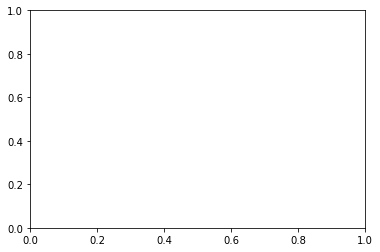

In [213]:
fig, axs = plt.subplots()

In [214]:
dataframe.plot(x="time", y="tec_filtered", ax=axs)

<AxesSubplot:xlabel='time'>

In [215]:
at = AnchoredText(anchored_text_label, loc='upper right', prop=dict(size=12), frameon=True,)

In [216]:
axs.add_artist(at)

In [217]:
# TODO: не работает показ, только сохранение, разобраться
# plt.show()
fig.savefig("fig.png")

In [218]:
day = get_date_by_number(year=2009, day_number=164)

In [169]:
day

datetime.date(2009, 6, 13)

In [128]:
dnum = get_day_number(year=2009, month=6, day=14)

In [129]:
dnum

165